## Combine behavior and imaging data

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')

In [41]:
from numpy import convolve, ones, where, mod
from pandas import read_csv
from os.path import exists
from os import makedirs
from json import load, dump
from os import mkdir

###Set directory and session information

In [23]:
directory = '/Volumes/freeman/Nick/mVR/sessions'
key = '000131'
path = directory + '/' + key

###Load session information

In [24]:
session = read_csv(path + '/behavior/session.csv')

### Load frames per volume

In [25]:
with open(path + '/summary/meta.json') as infile:
    meta = load(infile)
framesPerVolume = meta['nplanes']
numberImagingVolumes = meta['shape'][0]

### Extract acquisition and volume trigger information

Get frame onsets and determine number of frames

In [26]:
frames = session['frames'].diff()==1
totalFrames = frames.sum()
print totalFrames

44


Determine number of scanimage acquisitions

In [27]:
gap = 10

In [28]:
session['acquisitions'] = convolve(session['frames'],ones(gap)/gap,'same') > 0
session['acquisitions'] = session['acquisitions'].astype('float')

In [29]:
tmp = session['acquisitions'].diff()==1
session['acquisitionNumber'] = tmp.cumsum()-1
numberAcquisitions = session['acquisitionNumber'].max()+1
print numberAcquisitions

1


Convert to volumes and check if last volume trigger in each acquisition is incomplete and if so delete

In [30]:
session['volumes'] = 0
for acq in range(0,session['acquisitionNumber'].max()+1):
    currentAcq = session['acquisitionNumber'] == acq
    currentFrames = frames & currentAcq
    frameNums = currentFrames.cumsum()-1
    currentVolumes = (frameNums.mod(framesPerVolume)==0) & currentFrames
    finalVolume = mod(currentFrames.sum(),framesPerVolume)
    if finalVolume:
        last = where(currentVolumes)[0][-1]
        currentVolumes[last] = 0
    session['volumes'] = session['volumes'] | currentVolumes

In [31]:
numberVolumes = session['volumes'].sum()

###Save synchronization meta data

In [32]:
sync = {'numberAcquisitions':numberAcquisitions, 'totalFrames':totalFrames, 'framesPerVolume':framesPerVolume,
       'numberVolumes':numberVolumes}

In [33]:
print sync

{'numberAcquisitions': 1, 'totalFrames': 44, 'numberVolumes': 44, 'framesPerVolume': 1}


In [34]:
with open(path + '/behavior/sync.json', 'w') as outfile:
    dump(sync, outfile, indent=2)

###Check right number of imaging volumes

In [37]:
assert(numberImagingVolumes ==  sync['numberVolumes'])

###Downsample to volumes and save results

In [38]:
covariates = session[session.volumes]

In [42]:
if not exists(path + '/covariates'):
    makedirs(path + '/covariates')

In [43]:
covariates.to_csv(path + '/covariates/covariates.csv')

# Inspect triggers

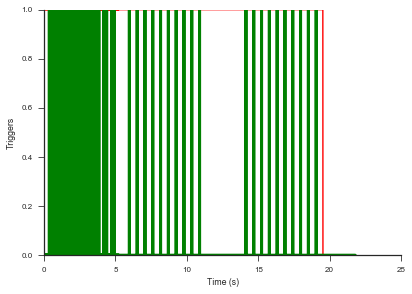

In [44]:
plt.plot(session.allTime,session.acquisitions,'r');
plt.plot(session.allTime,frames);
plt.plot(session.allTime,session.volumes,'g',linewidth=3);
plt.ylabel('Triggers')
plt.xlabel('Time (s)')
#plt.xlim([0, .5])
sns.despine()